# Supplementary analysis

This notebook contains supplementary analysis, not included in the paper draft, addressing the following questions:

- Are predictions of spiking systematically shifted in time, depending on the neuron identity and the algorithmus?

- Are some algorithms better than others in predicting the spiking activity of a neuron, depending on how well this neuron's spiking activity is predicted by all algorithms on average?

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spikefinder_eval as se

sns.set_style('whitegrid')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [54]:
data = pd.read_csv('data/results_24_07_17.csv', 
                   usecols=['algo', 'dset', 'measure', 'split', 'value', 
                           'rel value','cell'])

In [55]:
# determine order of algorithms   
gdata = data[data['measure']=='corr'].groupby(['algo', 'split'])['value','rel value'].mean().reset_index()
gdata = gdata[gdata['split']=='test'].sort_values(by='value', ascending=0)

order = gdata['algo'].as_matrix()

In [56]:
dsets = ['1.test', '2.test', '3.test', '4.test', '5.test']
#dsets = ['1.train', '2.train', '3.train', '4.train', '5.train']

## 1. Systematic delays of predictions

For each algorithm and each dataset and each cell, both the predictions and the ground truth are loaded.

Then, the correlation function between ground truth and prediction is computed for various time lags.

The maximum correlation indicates the optimal time lag.

This delay value is refined using a Gaussian fit of the correlation function around the maximum ('center_shift').

In [57]:
Xcorr_max = np.empty((12,5,15))
Xcorr_max[:] = np.NAN

p_columns = ['algo', 'dataset', 'delay', 'delay2']
p_index = np.arange(396)
p_counter = 0

df = pd.DataFrame(columns = p_columns, index = p_index)

for a, algo in enumerate(order):
    print(algo)

    for d, dset in enumerate(dsets):
        file = 'data/raw/truth/{}.spikes.csv'.format(dset)
        truth = se.load(file)
        
        file = 'data/raw/{}/{}.spikes.csv'.format(algo, dset)
        data = se.load(file)
        
        if algo=='machado':
            data = data.iloc[:,1::]

        downsample = 1
        counter = 0
        for column in data:
            x = data[column]
            y = truth[column]
            naninds = np.isnan(x) | np.isnan(y)
            x = x[~naninds]
            y = y[~naninds]
            x = se._downsample(x, downsample)
            y = se._downsample(y, downsample)

            ml = min([len(x),len(y)])

            x = x[0:ml]
            y = y[0:ml]
            
            if not len(x) == len(y):
                raise Exception('mismatched lengths %s and %s' % (len(x), len(y)))
            
            window_size = 35
            Xcorr = np.zeros(window_size*2,)
            for delay in range(-window_size,window_size):
                x_shifted = np.roll(x,delay)
                Xcorr[delay+window_size] = np.correlate(x_shifted,y)
                
                
            First_guess = np.argmax(Xcorr)
            if First_guess-7 >= 0:
                XcorrLocal = Xcorr[First_guess-7:First_guess+7]
                X = np.arange(XcorrLocal.size)
                center_shift = np.sum(X*XcorrLocal)/np.sum(XcorrLocal)
            else:
                center_shift = 0
            
            Xcorr_max[a,d,counter] = (First_guess +(center_shift-7) -window_size)*10
 
            counter += 1
            
            df.algo[p_counter] = algo
            df.dataset[p_counter] = d
            df.delay[p_counter] = (np.argmax(Xcorr)-window_size)*10
            df.delay2[p_counter] = (np.argmax(Xcorr)-window_size +(center_shift-7))*10
            p_counter += 1
            

df[['delay']] = df[['delay']].apply(pd.to_numeric)
df[['delay2']] = df[['delay2']].apply(pd.to_numeric)

deneux
chenkov
speiser
mineault
rupprecht
friedrich
pachitariu
bolte
machado
ringach
stm
oopsi


### Plot delays

Plot the delays for all algorithms (y-axis), all datasets (colors) and all neurons (single dots).

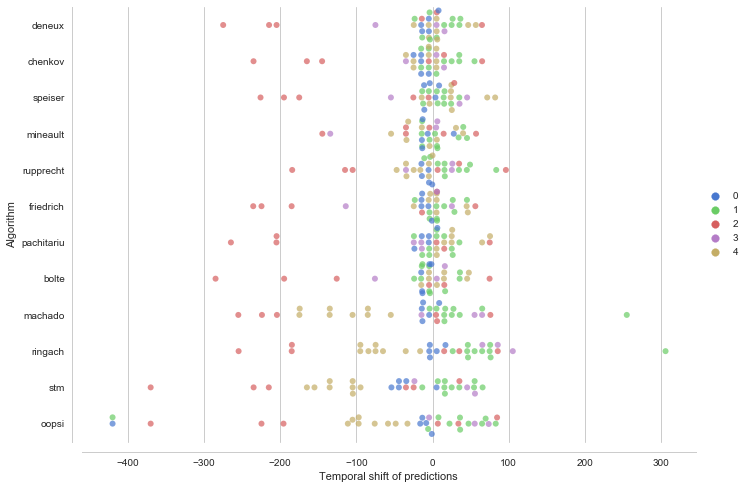

In [58]:
plt.rcParams["figure.figsize"] = (11,8)

f = plt.figure(1)
idx = (~pd.isnull(df['delay']))
ax = sns.swarmplot(data=df[idx], x='delay2', y='algo',hue='dataset',palette="muted", alpha=.7, size=6 , orient='h')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Temporal shift of predictions')
plt.ylabel('Algorithm')
sns.despine(offset=10)

### Plot delays, averaged for each dataset/algorithm

Most algorithms predict most datasets with close to optimal delay (indicated in milliseconds), except for dataset 3, where a systematic delay can be observed for all algorithms except Algorithm 4. Interestingly, this delay seems to be reduced especially for DNN algorithms (2, 4, 5).

The second plot shows not the average of delays, but the standard deviation. Standard deviation is high for dataset 3 for most algorithms, indicating that predictions are not only systematically delayed, but also jittered.

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5]), <a list of 12 Text yticklabel objects>)

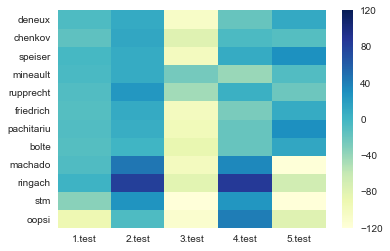

In [59]:
plt.rcParams["figure.figsize"] = (6,4)

plt.figure(2)
ax = sns.heatmap(np.nanmean(Xcorr_max, axis=2),
                 vmin=-120, vmax=120, xticklabels=dsets, yticklabels=order,cmap="YlGnBu")
plt.yticks(rotation=0)

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5]), <a list of 12 Text yticklabel objects>)

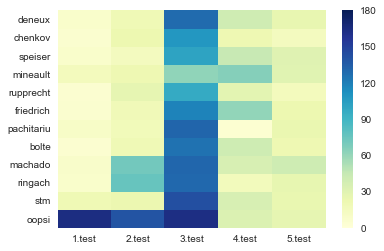

In [60]:
plt.rcParams["figure.figsize"] = (6,4)

plt.figure(3)
ax = sns.heatmap(np.nanstd(Xcorr_max, axis=2),
                 vmin=0, vmax=180, xticklabels=dsets, yticklabels=order,cmap="YlGnBu")
plt.yticks(rotation=0)

## 2. Ranking neurons according to how easy their spiking can be predicted

The idea of this analysis is to find out whether some algorithms are better or worse than others when it comes to predicting spikes for neurons that are difficult to predict (e.g., low SNR of the recording).

To this end, for each neuron the average correlation with predictions of the Top 10 algorithms is computed, and neurons are ranked accordingly.

Afterwards, the correlation coefficient as a performance measure for each algorithm is plotted, with all neurons ranked as described.

This is done both for the test data and the training data. It is clear from these plots that most algorithms were good at predicting similar neurons (both test and training data), with some exceptions (algorithms 4, 8; training data set).

### For test data

In [61]:
dsets = ['1.test', '2.test', '3.test', '4.test', '5.test']

Neuron_corr = np.zeros((32,12))
Neuron_dataset = np.zeros((32,))

for a, algo in enumerate(order):
    neuron_counter = 0
    for d, dset in enumerate(dsets):
        
        file = 'data/raw/{}/{}.spikes.csv'.format(algo, dset)
        data = se.load(file)
        if algo=='machado':
            data = data.iloc[:,1::]
            
        file = 'data/raw/truth/{}.spikes.csv'.format(dset)
        truth = se.load(file)
    
        c = np.array(se.score(data, truth, method='corr', downsample=4))
        Neuron_corr[neuron_counter:neuron_counter+c.shape[0],a] = c
        Neuron_dataset[neuron_counter:neuron_counter+c.shape[0]] = d
        
        neuron_counter += c.shape[0]

/home/pierre/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/pierre/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


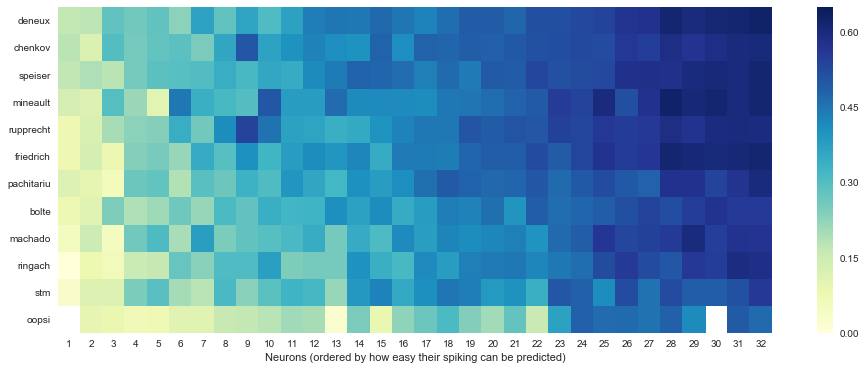

In [62]:
Ranking = np.median(Neuron_corr[:,0:10],axis=1)
rank_indizes = np.argsort(Ranking)

plt.rcParams["figure.figsize"] = (16,6)

plt.figure(5)
ax = sns.heatmap(np.transpose(Neuron_corr[rank_indizes,:]), vmin=0, vmax=0.65, xticklabels=np.arange(32)+1, yticklabels=order,cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xlabel('Neurons (ordered by how easy their spiking can be predicted)')

### For training data

In [63]:
dsets = ['1.train', '2.train', '3.train', '4.train', '5.train']

Neuron_corr = np.zeros((60,12))
Neuron_dataset = np.zeros((60,))

for a, algo in enumerate(order):
    neuron_counter = 0
    for d, dset in enumerate(dsets):
        
        file = 'data/raw/{}/{}.spikes.csv'.format(algo, dset)
        data = se.load(file)
        if algo=='machado':
            data = data.iloc[:,1::]
            
        file = 'data/raw/truth/{}.spikes.csv'.format(dset)
        truth = se.load(file)
    
        c = np.array(se.score(data, truth, method='corr', downsample=4))
        Neuron_corr[neuron_counter:neuron_counter+c.shape[0],a] = c
        Neuron_dataset[neuron_counter:neuron_counter+c.shape[0]] = d
        
        neuron_counter += c.shape[0]

/home/pierre/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/pierre/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


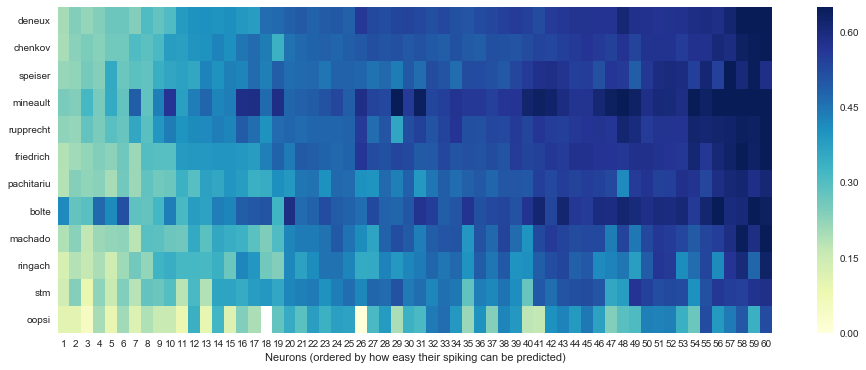

In [64]:
Ranking = np.median(Neuron_corr[:,0:10],axis=1)
rank_indizes = np.argsort(Ranking)

plt.rcParams["figure.figsize"] = (16,6)

plt.figure(5)
ax = sns.heatmap(np.transpose(Neuron_corr[rank_indizes,:]), vmin=0, vmax=0.65, xticklabels=np.arange(60)+1, yticklabels=order,cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xlabel('Neurons (ordered by how easy their spiking can be predicted)')